Make sure imblearn is installed:

In [1]:
!pip install imblearn

Note: if you are using sklearn=1.3, it needs to be downgraded for the code below to work:

!pip uninstall scikit-learn --yes

!pip uninstall imblearn --yes

!pip install scikit-learn==1.2.2

!pip install imblearn

In [2]:
# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

sns.set_theme(palette="Set2")

# execution time
from timeit import default_timer as timer
from datetime import timedelta

# increase column width
pd.set_option('display.max_colwidth', 200)

# silence warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Load the data

In [3]:
import os
import tarfile
import urllib


# the file is archived with tar and gunzip
URL = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz"

def get_dataframe():
    global URL
    
    # if the "datasets" folder does not exist, create it
    if not os.path.exists("datasets"):
        os.makedirs("datasets")
    
    # if the archived file does not exist, download it
    if not os.path.exists("datasets/housing.tgz"):
        urllib.request.urlretrieve(URL, "datasets/housing.tgz")
    
    # if the unpacked file does not exist, unpack it
    if not os.path.exists("datasets/housing.csv"):
        infile = tarfile.open("datasets/housing.tgz")
        infile.extractall(path="datasets")
        infile.close()
    
    # load the dataframe
    return pd.read_csv("datasets/housing.csv")

df = get_dataframe()

# Train-test split

In [4]:
df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                          labels=[1, 2, 3, 4, 5])
trainset, testset = train_test_split(df, test_size=0.2, random_state=7,
                                     stratify=df["income_cat"])
del trainset["income_cat"]
del testset["income_cat"]

# Repeat initial preprocessing steps

## Feature engineering

In [5]:
# create two new features
trainset["rooms_per_household"] = trainset["total_rooms"]/trainset["households"]
trainset["population_per_household"] = trainset["population"]/trainset["households"]
testset["rooms_per_household"] = testset["total_rooms"]/testset["households"]
testset["population_per_household"] = testset["population"]/testset["households"]

# rename "ISLAND" to "NEAR OCEAN"
trainset["ocean_proximity"] = trainset["ocean_proximity"].replace("ISLAND", "NEAR OCEAN")
testset["ocean_proximity"] = testset["ocean_proximity"].replace("ISLAND", "NEAR OCEAN")
trainset["ocean_proximity"].unique()

# delete capped values
trainset.drop(trainset[trainset["median_house_value"] >= 500001].index, inplace=True)
testset.drop(testset[testset["median_house_value"] >= 500001].index, inplace=True)

## Dummy variables

In [6]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(drop="first", sparse=False)

# categorical columns to transform
cat_cols = ["ocean_proximity"]

# fit an encoder and transform the **trainset**
cat_vals = trainset[cat_cols]

transformed = one_hot_encoder.fit_transform(cat_vals)

# the names of the new columns are the unique values of "ocean_proximity"
new_col_names = one_hot_encoder.get_feature_names_out(cat_cols)

# put the transformed data as columns in the trainset dataframe
for i, new_col_name in enumerate(new_col_names):
    trainset[new_col_name] = transformed[:,i]

# delete the categorical column
del trainset['ocean_proximity']

# transform the **testset** using the encoder fitted on trainset
cat_vals = testset[cat_cols]
transformed = one_hot_encoder.transform(cat_vals)

# put the transformed data as columns in the testset dataframe
for i, new_col_name in enumerate(new_col_names):
    testset[new_col_name] = transformed[:,i]

# delete the categorical column also in the test set
del testset['ocean_proximity']

C:\Users\pekarv\Anaconda3\envs\.env\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Separate predictors and target

In [7]:
ytrain = trainset["median_house_value"].copy()
Xtrain = trainset.drop("median_house_value", axis=1)
ytest = testset["median_house_value"].copy()
Xtest = testset.drop("median_house_value", axis=1)

# Pipeline

In [8]:
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


class LogTransformer:

    def __init__(self, cols, **kwargs):
        self.cols = cols

    def fit(self, X, y=None, **kwargs):
        return self

    def transform(self, X, y=None, **kwargs):
        for col in self.cols:
            X[:, col] = np.log(X[:, col] + 1)
        return X


class OutlierDetectionWrapper:

    def __init__(self, **kwargs):
        self.clf = IsolationForest(**kwargs)

    def fit_resample(self, X, y):
        yhat = self.clf.fit(X).predict(X)
        return X[yhat != -1], y[yhat != -1]

    def set_params(self, **kwargs):
        self.clf.set_params(**kwargs)

# Tuning hyperparameters

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
def run_pipeline(hp_grid):

    # indices of columns to be log-transformed
    col_idx = [Xtrain.columns.get_loc(x) for x in 
               ["total_rooms", "total_bedrooms", "population", "households", "median_income"]]
    
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('logtransformer', LogTransformer(col_idx)),
        ('iforest', OutlierDetectionWrapper(n_estimators=50, random_state=7)),
        ('fsel', SelectKBest(r_regression)),
        ('scaler', StandardScaler()),
        ('dt', DecisionTreeRegressor(random_state=7))
    ])
    
    best_hp = {
        'dt__max_depth': [25], 
        'dt__max_leaf_nodes': [16000], 
        'dt__min_samples_leaf': [15], 
        'dt__min_samples_split': [50], 
        'fsel__k': [13], 
        'iforest__contamination': [0.001],
    }

    best_hp.update(hp_grid)
    
    # we'll use 10-fold cross-validation
    grid_search = GridSearchCV(pipe, best_hp, cv=10,
                               scoring='neg_root_mean_squared_error', 
                               return_train_score=True, verbose=0)
    
    grid_search.fit(Xtrain, ytrain)
    
    cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
    cv_results["mean_train_score"] = -cv_results["mean_train_score"]
    cv_results["mean_test_score"] = -cv_results["mean_test_score"]
    cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                         )/cv_results["mean_train_score"]

    # bar plot
    hp_name = list(hp_grid.keys())[0]
    hp_settings = [x[hp_name] for x in cv_results["params"].values.tolist()]
    diff_vals = np.abs(cv_results["diff, %"].values)
    df_plot = pd.DataFrame(data={hp_name: hp_settings, 'diff, %': diff_vals}).set_index(hp_name)

    # table
    table = cv_results[["params", "diff, %"]].sort_values('diff, %')
    
    return table, df_plot

## Effect of outlier removal

In [11]:
start = timer()

hp_grid = {
    'iforest__contamination': [0.001, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
}
table, plot = run_pipeline(hp_grid)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

table

Execution time HH:MM:SS: 0:00:48.932242


,params,"diff, %"
0,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-18.576223
1,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.025}",-16.707972
2,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.05}",-15.542166
3,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.075}",-15.511608
5,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.125}",-13.502164
4,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.1}",-13.236068
7,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.175}",-12.400638
6,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.15}",-12.345063
8,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.2}",-11.990645


<Axes: xlabel='iforest__contamination'>

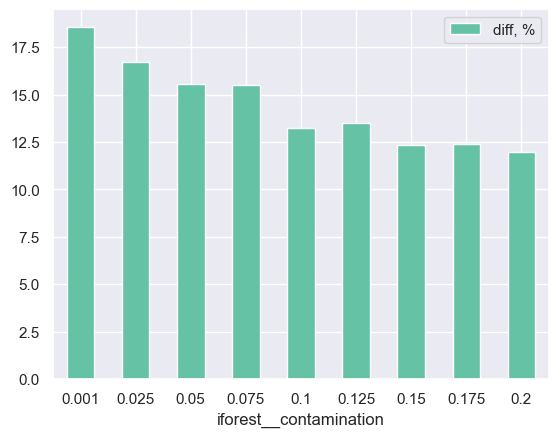

In [12]:
plot.plot(kind="bar", rot=0)

## Effect of feature selection

In [13]:
start = timer()

hp_grid = {
    'fsel__k': [3, 5, 7, 9, 11, 13],
}
table, plot = run_pipeline(hp_grid)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

table

Execution time HH:MM:SS: 0:00:31.323783


,params,"diff, %"
3,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 9, 'iforest__contamination': 0.001}",-19.305200
4,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 11, 'iforest__contamination': 0.001}",-18.685500
5,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-18.576223
2,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 7, 'iforest__contamination': 0.001}",-16.885446
1,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 5, 'iforest__contamination': 0.001}",-15.779323
0,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 3, 'iforest__contamination': 0.001}",-14.062424


<Axes: xlabel='fsel__k'>

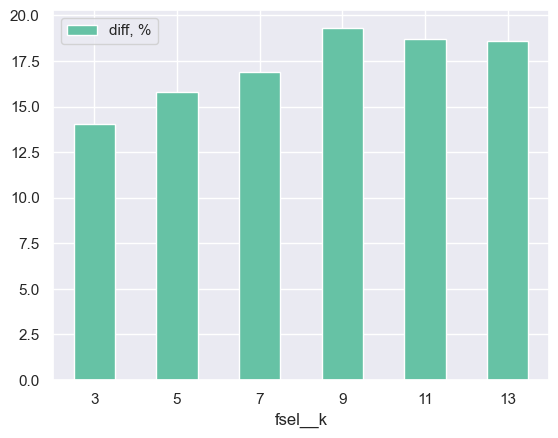

In [14]:
plot.plot(kind="bar", rot=0)

## Effect of max_depth

In [15]:
start = timer()

hp_grid = {
    'dt__max_depth': [2, 10, 15, 20, 25],
}
table, plot = run_pipeline(hp_grid)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

table

Execution time HH:MM:SS: 0:00:27.455084


,params,"diff, %"
3,"{'dt__max_depth': 20, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-18.576223
4,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-18.576223
2,"{'dt__max_depth': 15, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-18.416667
1,"{'dt__max_depth': 10, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-13.406252
0,"{'dt__max_depth': 2, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-0.194563


<Axes: xlabel='dt__max_depth'>

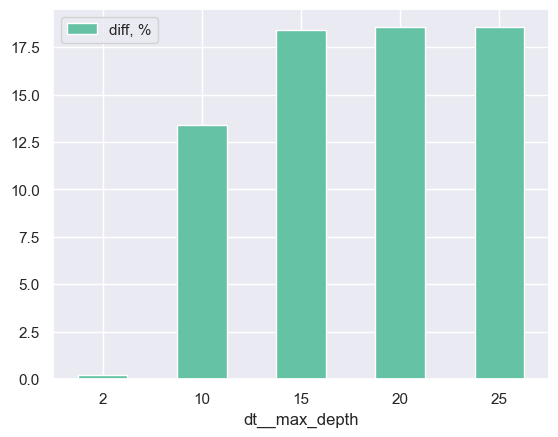

In [16]:
plot.plot(kind="bar", rot=0)

## Effect of min_samples_leaf

In [17]:
start = timer()

hp_grid = {
    'dt__min_samples_leaf': [1, 10, 20, 30, 40, 50],
}
table, plot = run_pipeline(hp_grid)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

table

Execution time HH:MM:SS: 0:00:33.554408


,params,"diff, %"
0,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-32.357009
1,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-21.644850
2,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 20, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-17.023639
3,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 30, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-13.131080
4,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 40, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-9.732912
5,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 50, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-7.827844


<Axes: xlabel='dt__min_samples_leaf'>

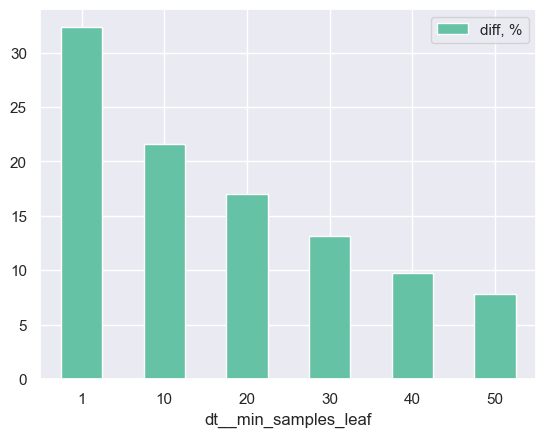

In [18]:
plot.plot(kind="bar", rot=0)

## Effect of min_samples_split

In [19]:
start = timer()

hp_grid = {
    'dt__min_samples_split': [2, 10, 20, 30, 40, 50],
}
table, plot = run_pipeline(hp_grid)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

table

Execution time HH:MM:SS: 0:00:33.669597


,params,"diff, %"
0,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 2, 'fsel__k': 13, 'iforest__contamination': 0.001}",-25.654746
1,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 10, 'fsel__k': 13, 'iforest__contamination': 0.001}",-25.654746
2,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 20, 'fsel__k': 13, 'iforest__contamination': 0.001}",-25.654746
3,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 30, 'fsel__k': 13, 'iforest__contamination': 0.001}",-25.654746
4,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 40, 'fsel__k': 13, 'iforest__contamination': 0.001}",-22.056154
5,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 16000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-18.576223


<Axes: xlabel='dt__min_samples_split'>

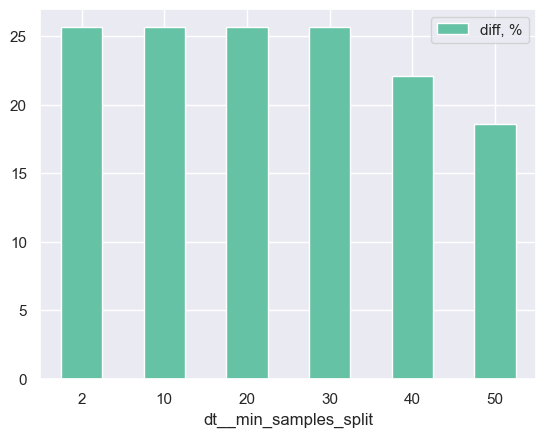

In [20]:
plot.plot(kind="bar", rot=0)

## Effect of max_leaf_nodes

In [21]:
start = timer()

hp_grid = {
    'dt__max_leaf_nodes': [2500, 5000, 7500, 10000, None]
}
table, plot = run_pipeline(hp_grid)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

table

Execution time HH:MM:SS: 0:00:28.057210


,params,"diff, %"
4,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': None, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-18.599132
0,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 2500, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-18.576223
1,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 5000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-18.576223
2,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 7500, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-18.576223
3,"{'dt__max_depth': 25, 'dt__max_leaf_nodes': 10000, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 50, 'fsel__k': 13, 'iforest__contamination': 0.001}",-18.576223


<Axes: xlabel='dt__max_leaf_nodes'>

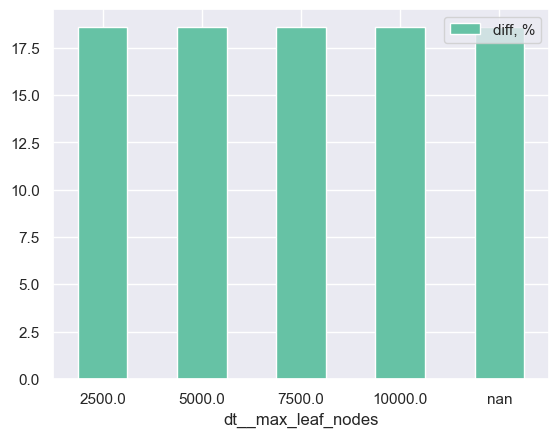

In [22]:
plot.plot(kind="bar", rot=0)